In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.externals.six import StringIO 
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from scipy import stats
from sklearn.metrics import make_scorer
import sklearn
from sklearn import decomposition
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import decomposition
from sklearn.model_selection import cross_val_score

# Pandas
import pandas as pd

# Numpy
import numpy as np
# Set random seed
np.random.seed(0)

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus

import warnings
warnings.filterwarnings("ignore")

In [26]:
raw = pd.read_csv('KeplerData.csv')
target_name = 'Exoplanet Archive Disposition'
feature_names = raw.columns[4:]
raw = raw[[target_name, *feature_names]]
print(raw.shape)
raw.head()

(9564, 99)


,Exoplanet Archive Disposition,Disposition Score,Not Transit-Like False Positive Flag,Stellar Eclipse False Positive Flag,Centroid Offset False Positive Flag,Ephermeris Match Indicates Contamination False Positive Flag,Orbital Period [days],Orbital Period Upper Uncertainty [days],Orbital Period Lower Uncertainty [days],Eccentricity,...,PRF Delta Delta SQ (OOT) [arcsec],PRF Delta Delta SQ (OOT) Unc.,PRF Delta Theta SQ (OOT) [arcsec],PRF Delta Theta SQ (OOT) Unc.,PRF Delta Alpha SQ (KIC) [arcsec],PRF Delta Alpha SQ (KIC) Unc.,PRF Delta Delta SQ (KIC) [arcsec],PRF Delta Delta SQ (KIC) Unc.,PRF Delta Theta SQ (KIC) [arcsec],PRF Delta Theta SQ (KIC) Unc.
0,CONFIRMED,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,0.0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,CONFIRMED,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,0.0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,0.0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,0.0,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,CONFIRMED,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,0.0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [43]:
# A quick look at the count of null values in the original data
# important_withnulls = raw[[*important_names[:5], target_name]]
# important_withnulls.describe()
# important_withnulls.isnull().sum()

In [34]:
# IMPUTE
# Fill Disposition Score with 0.5
raw_withoutna = raw[:]
raw_withoutna['Disposition Score'].fillna(.5, inplace=True)
# Fill flags with 0
flag_names = ['Not Transit-Like False Positive Flag', 'Stellar Eclipse False Positive Flag', 'Centroid Offset False Positive Flag', 'Ephermeris Match Indicates Contamination False Positive Flag']
raw_withoutna[flag_names].fillna(0, inplace=True)
# Fill all other nulls with median
raw_withoutna.fillna(raw_withoutna.median(), inplace=True)
# remove canidates for prediction (2244 rows)
data = raw_withoutna[raw_withoutna[target_name] != 'CANDIDATE']
# remove column 'Disposition Score' becuase it is not really a feature
data = data.drop(['Disposition Score'], axis=1)
feature_names = list(set(feature_names) - set(['Disposition Score']))
print(data.shape)
data.head()

(7320, 98)


,Exoplanet Archive Disposition,Not Transit-Like False Positive Flag,Stellar Eclipse False Positive Flag,Centroid Offset False Positive Flag,Ephermeris Match Indicates Contamination False Positive Flag,Orbital Period [days],Orbital Period Upper Uncertainty [days],Orbital Period Lower Uncertainty [days],Eccentricity,Impact Parameter,...,PRF Delta Delta SQ (OOT) [arcsec],PRF Delta Delta SQ (OOT) Unc.,PRF Delta Theta SQ (OOT) [arcsec],PRF Delta Theta SQ (OOT) Unc.,PRF Delta Alpha SQ (KIC) [arcsec],PRF Delta Alpha SQ (KIC) Unc.,PRF Delta Delta SQ (KIC) [arcsec],PRF Delta Delta SQ (KIC) Unc.,PRF Delta Theta SQ (KIC) [arcsec],PRF Delta Theta SQ (KIC) Unc.
0,CONFIRMED,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,0.0,0.146,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,0.0,0.586,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,FALSE POSITIVE,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,0.0,0.969,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,0.0,1.276,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,CONFIRMED,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,0.0,0.701,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [37]:
scoring = ['accuracy', 'precision', 'recall']
clf = RandomForestClassifier(random_state=0)
scores = cross_validate(clf, data[feature_names],
                        data[target_name]=='CONFIRMED', scoring=scoring,
                        cv=5, return_train_score=True)
print("Accuracy:\t\t", np.mean(scores['test_accuracy']))
print("Completeness:\t\t", np.mean(scores['test_recall']))
print("Contamination:\t\t", 1 - np.mean(scores['test_precision']))
print('\n')

Accuracy:		 0.9764974038301197
Completeness:		 0.9346717817561807
Contamination:		 0.009952414883388827




In [38]:
clf.fit(data[feature_names], data[target_name])
values = list(zip(data[feature_names], clf.feature_importances_))
#plt.barh(range(len(clf.feature_importances_)), [x[1] for x in values])
sortd = sorted(values, reverse = True, key= lambda x: x[1])
important_names = [s[0] for s in sortd]
sortd[:10]

[('PRF Delta Theta SQ (KIC) [arcsec]', 0.06899319007953764),
 ('Number of Planets', 0.057326862040056326),
 ('PRF Delta Theta SQ (OOT) [arcsec]', 0.05581137316891712),
 ('FW Offset Significance [percent]', 0.05505352971741947),
 ('Stellar Metallicity Lower Uncertainty [dex]', 0.043881203504930036),
 ('Stellar Effective Temperature Upper Uncertainty [K]', 0.04189221016030282),
 ('Not Transit-Like False Positive Flag', 0.04177843924647827),
 ('Planetary Radius Lower Unc. [Earth radii]', 0.04124176614715121),
 ('Planetary Radius [Earth radii].1', 0.03929780493689046),
 ('Stellar Effective Temperature Lower Uncertainty [K]', 0.037913166941020995)]

In [39]:
# Getting wwarning Variables are collinear
from statsmodels.stats.outliers_influence import variance_inflation_factor
highVIFS = [
    'Planetary Radius Lower Unc. [Earth radii]', 
    'Planetary Radius [Earth radii]',
    'Stellar Effective Temperature Upper Uncertainty [K]',
    'Transit Duration Upper Uncertainty [hrs]',
    'Stellar Metallicity Upper Uncertainty [dex]',
]
noHighVIFS = list(set(important_names[:25]) - set(highVIFS))
X = data[noHighVIFS]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif
# [x for x in data.columns if x.startswith('Stellar Effective Temperature Upper Uncertaint')]

,VIF Factor,features
0,7.519812,PRF Delta Theta SQ (OOT) [arcsec]
1,1.452976,FW Offset Significance [percent]
2,1.303554,Maximum Multiple Event Statistic
3,2.246199,Stellar Eclipse False Positive Flag
4,2.448134,Number of Planets
5,1.549029,Transit Duration Lower Uncertainty [hrs]
6,2.367219,Planetary Radius [Earth radii].1
7,2.385344,Not Transit-Like False Positive Flag
8,2.280174,Planetary Radius Lower Uncertainty [Earth radii]
9,3.713473,Stellar Mass Upper Uncertainty [Solar mass]


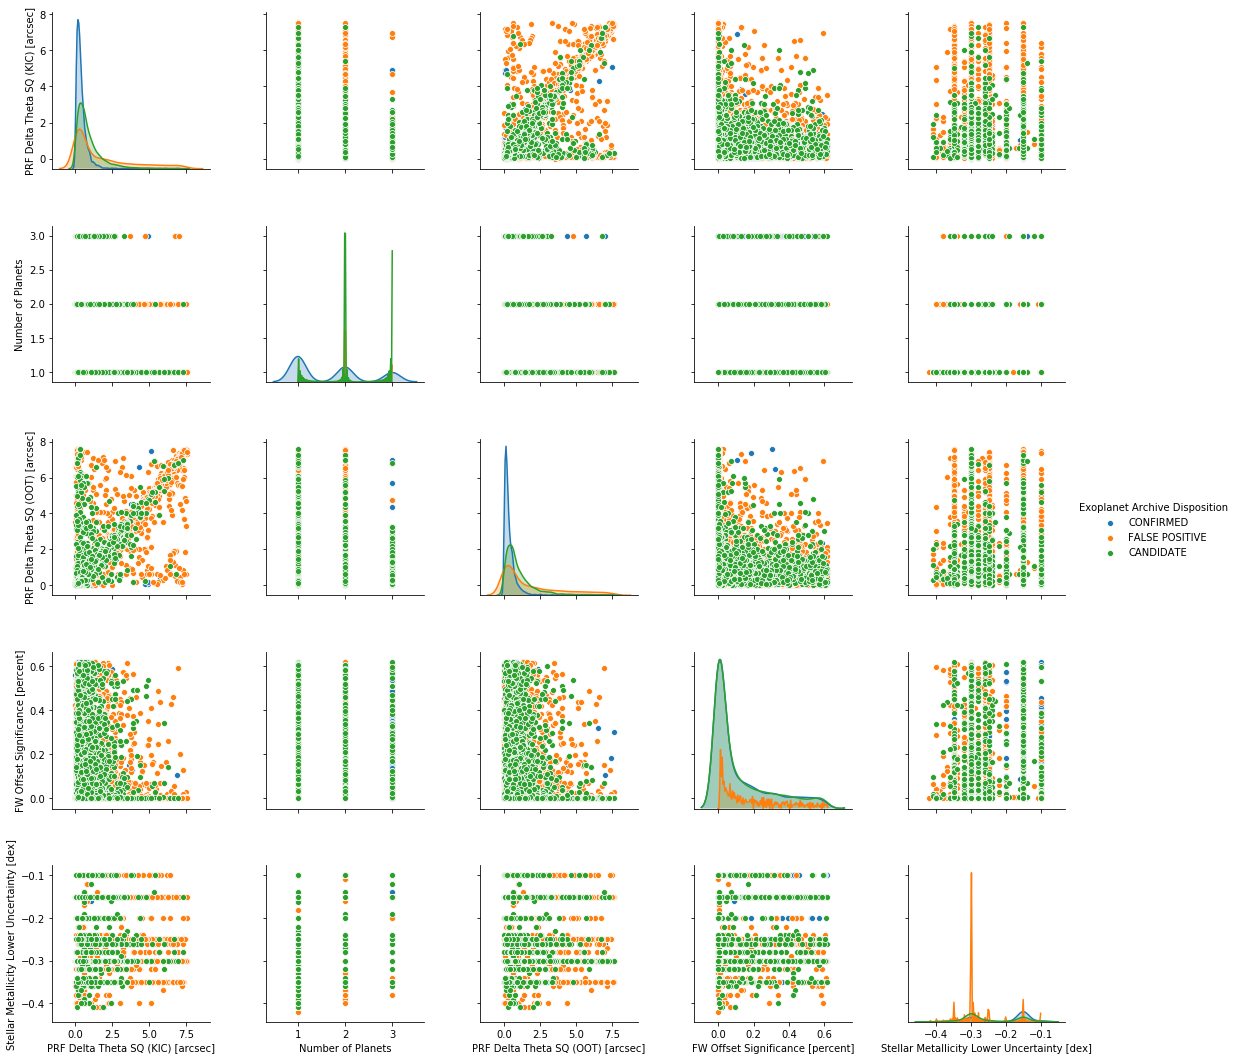

In [44]:
# look at the 5 most important features with the canidate data
i5 = important_names[:5]
df5 = raw[[*i5, target_name]]
i3 = important_names[:3]
# remove outliers for graphing
df5[i5] = df5[i5].mask(df5[i5].sub(df5[i5].mean()).div(df5[i5].std()).abs().gt(2))
# log transform for graphing
# df5[important_names[0]] = df5[important_names[0]].apply(np.log)
# df5[important_names[1]] = df5[important_names[1]].apply(np.log)
# df5[important_names[2]] = df5[important_names[2]].apply(np.log)
# df5[important_names[3]] = df5[important_names[3]].apply(np.log)
# df5[important_names[4]] = df5[important_names[4]].apply(np.log)
sns.pairplot(df5, hue=target_name, height=3)
# fig, axs = plt.subplots(ncols=5)
# for i in range(5):
#     df5_0 = df5.loc[df5[target_name] == 'CONFIRMED']
#     df5_1 = df5.loc[df5[target_name] == 'FALSE POSITIVE']
#     df5_2 = df5.loc[df5[target_name] == 'CANDIDATE']

#     sns.distplot(df5_0[i5[i]], hist=False)
#     sns.distplot(df5_1[i5[i]], hist=False)
#     sns.distplot(df5_2[i5[i]], hist=False)

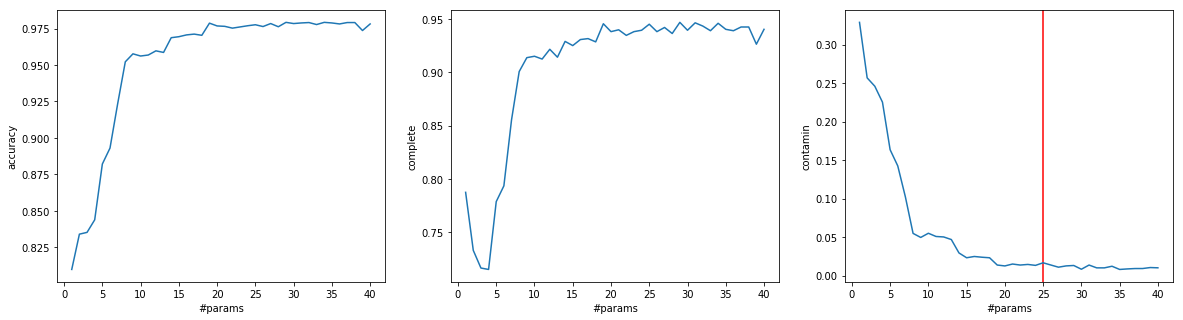

In [45]:
# Rerun using only the top most important features
test = []
for i in range(1, 41):
    imp = important_names[:i]
    clf = RandomForestClassifier()
    clf.fit(data[imp], data[target_name])
    scoring = ['accuracy', 'precision', 'recall']
    scores = cross_validate(clf, data[imp],
                            data[target_name]=='CONFIRMED', scoring=scoring,
                            cv=5, return_train_score=True)
    test.append((i, np.mean(scores['test_accuracy']), np.mean(scores['test_recall']), 1 - np.mean(scores['test_precision'])))
#     print("With #:\t\t", i)
#     print("Accuracy:\t\t", np.mean(scores['test_accuracy']))
#     print("Completeness:\t\t", np.mean(scores['test_recall']))
#     print("Contamination:\t\t", 1 - np.mean(scores['test_precision']))
#     print('\n')
df_test = pd.DataFrame(test, columns=['#params', 'accuracy', 'complete', 'contamin'])
df_test
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
sns.lineplot(x="#params", y="accuracy", data=df_test, ax=axs[0])
plt.axvline(x=25, color='red')
sns.lineplot(x="#params", y="complete", data=df_test, ax=axs[1])
sns.lineplot(x="#params", y="contamin", data=df_test, ax=axs[2])

In [47]:
top_names = important_names[:25]

In [48]:
names = ["Nearest Neighbors", #"RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(n_neighbors=10),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

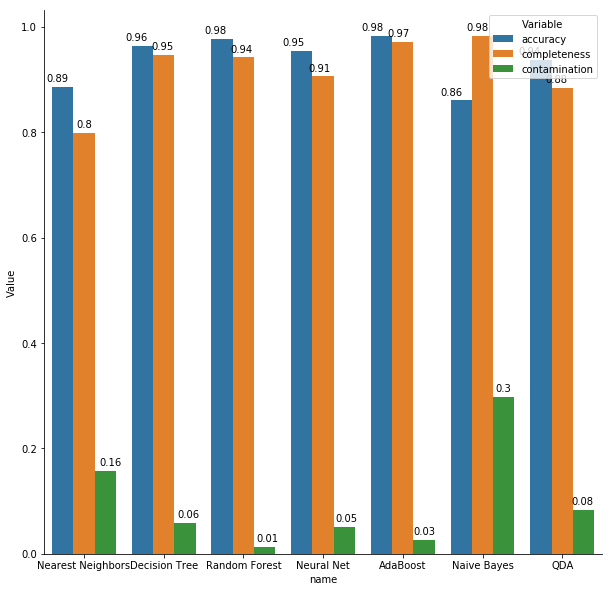

In [51]:
scoring = ['accuracy', 'precision', 'recall']
scores_list = []
# iterate over classifiers
for name, clf in zip(names, classifiers):
    scores = cross_validate(clf, data[top_names],
                            data[target_name]=='CONFIRMED', scoring=scoring,
                            cv=5, return_train_score=True)
    scores_list.append([name, np.mean(scores['test_accuracy']), np.mean(scores['test_recall']), 1 - np.mean(scores['test_precision'])])

scores_df = pd.DataFrame(scores_list, columns=['name', 'accuracy', 'completeness', 'contamination'])
fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = (
    scores_df.set_index('name')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)
g = sns.barplot(x='name', y='Value', hue='Variable', data=tidy, ax=ax1)
for index, row in tidy.iterrows():
    g.text((row.name-1)/3.04,row.Value + .01, round(row.Value,2), color='black', ha="center")
sns.despine(fig)

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
#     'min_samples_split': [2, 5, 10, 20], 
    'n_estimators' : [500],
    'max_depth': [10],
    'max_features': [10]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

X_train, X_test, y_train, y_test = \
    train_test_split(data[important_names[:20]],
                     data[target_name] == 'CONFIRMED',
                     test_size=.4,
                     random_state=42)

In [53]:
def grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=4)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)
    results = pd.DataFrame(grid_search.cv_results_)
    bestResults = results[results.params == grid_search.best_params_]
    completeness = float(bestResults['mean_test_recall_score'])
    print('Completion:', completeness)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

grid_search = grid_search_wrapper()
# confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], normalize=True)
# sns.heatmap(confusion, annot=True)

Best params for recall_score
{'max_depth': 10, 'max_features': 10, 'n_estimators': 500}
Completion: 0.9605114228493236

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg      1955        18
pos        35       920


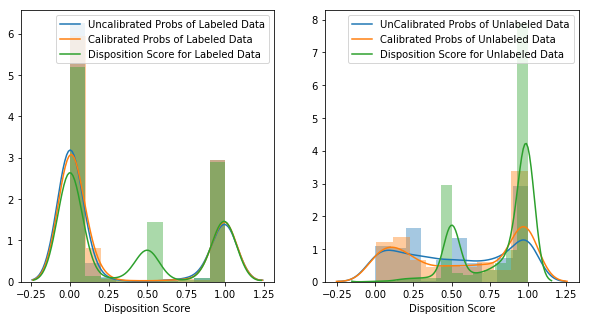

In [55]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split


# # Create dataset of classification task with many redundant and few
# # informative features
clf = RandomForestClassifier()
X_labeled, y = data[important_names[:20]], data[target_name]
clf.fit(X_labeled, y)
X_candidates = raw_withoutna[important_names[:20]][raw[target_name] == 'CANDIDATE']
calibrated = CalibratedClassifierCV(clf, method='isotonic')
calibrated.fit(X_labeled, y)

probs_labeled = [x[0] for x in clf.predict_proba(X_labeled)]
probs_calib_labeled = [x[0] for x in calibrated.predict_proba(X_labeled)]
probs_unlabeled = [x[0] for x in clf.predict_proba(X_candidates)]
probs_calib_unlabeled = [x[0] for x in calibrated.predict_proba(X_candidates)]
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
sns.distplot(probs_labeled, ax=axs[0], kde_kws={"label": "Uncalibrated Probs of Labeled Data"})
sns.distplot(probs_calib_labeled, ax=axs[0], kde_kws={"label": "Calibrated Probs of Labeled Data"})
sns.distplot(raw['Disposition Score'][raw[target_name] != 'CANDIDATE'].dropna(), ax=axs[0], kde_kws={"label": "Disposition Score for Labeled Data"})
sns.distplot(probs_unlabeled, ax=axs[1], kde_kws={"label": "UnCalibrated Probs of Unlabeled Data"})
sns.distplot(probs_calib_unlabeled, ax=axs[1], kde_kws={"label": "Calibrated Probs of Unlabeled Data"})
sns.distplot(raw['Disposition Score'][raw[target_name] == 'CANDIDATE'].dropna(), ax=axs[1], kde_kws={"label": "Disposition Score for Unlabeled Data"})

In [ ]:
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(data[important_names[:25]])
# X_scaled = scaler.transform(data[important_names[:25]])
# tsne = TSNE(2, random_state=42)
# X_tsne = tsne.fit_transform(X_scaled)

# data_tsne = pd.DataFrame(X_tsne)
# data_tsne[target_name] = data[target_name]

# n = 1
# for (category, row) in data_tsne.groupby(by=target_name):
#     n = n + 1
#     plt.scatter(row[0], row[1], color = (n*0.2, 0.25, 0.33, 1))

# #plt.legend(data_tsne["category"].unique())
# plt.xlabel("First t-SNE Component")
# plt.ylabel("Second t-SNE Component")
# plt.show()